In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import qcodes as qc
import os
from qcodes import (initialise_or_create_database_at,
                    load_by_guid,
                    load_or_create_experiment)

import matplotlib.pyplot as plt

db_name = "../data/GeSiNW_fully_autonomous_tuning.db" # Database name
sample_name = "Butch" # Sample name
exp_name = "Qubit_Search" # Experiment name

db_file_path = os.path.join(os.getcwd(), db_name)
qc.config.core.db_location = db_file_path
initialise_or_create_database_at(db_file_path)

experiment = load_or_create_experiment(experiment_name = exp_name,
                                       sample_name = sample_name)

plt.style.use('default')
import sys
sys.path.append('../')

# Load data

In [2]:
# local_ids = [293, 294]
# from qcodes.dataset import (
#     Measurement,
#     connect,
#     extract_runs_into_db,
#     load_experiment_by_name,
#     load_or_create_experiment,
# )
# source_conn = connect(db_name)
# target_path = "../data/GeSiNW_fully_autonomous_tuning.db"
# target_conn = connect(target_path)
# for _id in local_ids:
#     extract_runs_into_db(db_name, target_path, _id)

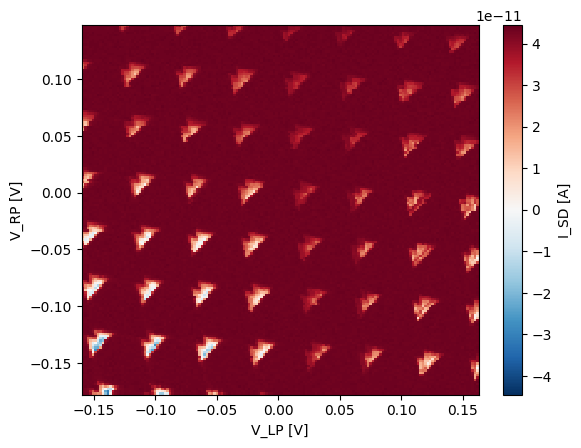

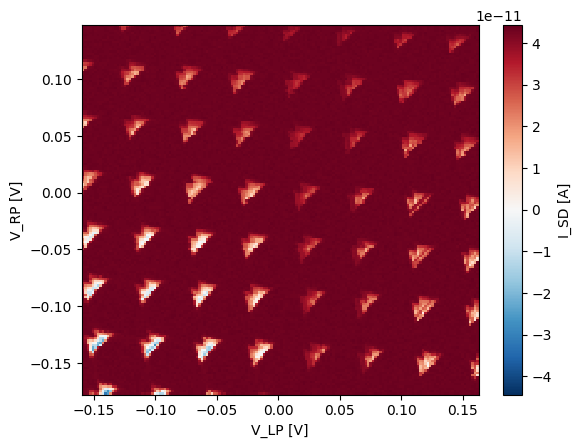

In [3]:
ds_low_magnet = load_by_guid('cd3eb415-0000-0000-0000-018a63a2baad')
ds_low_magnet.to_xarray_dataset()["I_SD"].plot()
plt.show()
ds_high_magnet = load_by_guid('7a47154b-0000-0000-0000-018a634ae9cc')
ds_high_magnet.to_xarray_dataset()["I_SD"].plot()

In [4]:
data_high_magnet_xarray = ds_high_magnet.to_xarray_dataset()
data_low_magnet_xarray = ds_low_magnet.to_xarray_dataset()

# Apply Method

In [7]:
# from pipelines.utils import draw_boxes_and_preds
from signal_processing import EnsembleClassifier
from signal_processing.bias_triangle_processing.bias_triangle_detection import btriangle_detection, btriangle_properties
from signal_processing.bias_triangle_processing.bias_triangle_detection import btriangle_location_detection

invert_current = True
bias_direction = 'positive_bias'
if invert_current:
    data_high_magnet_analysis = -data_high_magnet_xarray["I_SD"].to_numpy()
    data_low_magnet_analysis = -data_low_magnet_xarray['I_SD'].to_numpy()
else:
    data_high_magnet_analysis = data_high_magnet_xarray['I_SD'].to_numpy()
    data_low_magnet_analysis = data_low_magnet_xarray['I_SD'].to_numpy()


axes_values = []
axes_values_names = []
axes_units = []

for item, n in dict(data_high_magnet_xarray.dims).items():
    axes_values.append(data_high_magnet_xarray[item].to_numpy())
    axes_values_names.append(data_high_magnet_xarray[item].long_name)
    axes_units.append(data_high_magnet_xarray[item].unit)

offset_px = 10
(
    anchor,
    peaks_px,
    peaks,
    all_triangles_px,
    all_triangles,
    fig,
) = btriangle_location_detection.get_locations(
    data_high_magnet_analysis,
    axes_values[1],
    axes_values[0],
    axes_values_names[1],
    axes_values_names[0],
    return_figure=True,
    plot=True,
    offset_px=offset_px,
)

psb_model = 'lenet'
folder_path_to_nn = "../signal_processing/psb_classifier/saved_networks/20230830_lenet_all_real_data_nanowire_low_res/"
network_names = 'all_real_data'
if psb_model == "lenet":
    psb_classifier = EnsembleClassifier(
        folder_path_to_nn=folder_path_to_nn, network_names=network_names
    )
else:
    psb_classifier = EnsembleClassifier(
        "../signal_processing/psb_classifier/saved_networks/",
        model_type="resnet18",
    )

sidelength = np.max(peaks_px)
bias_direction = "positive_bias"
if bias_direction == "positive_bias":
    flip_bias = False
elif bias_direction == "negative_bias":
    flip_bias = True
else:
    raise NotImplementedError

predictions = psb_classifier.predict_from_large_scan(
    data_low_magnet_analysis,
    data_high_magnet_analysis,
    all_triangles_px,
    sidelength=sidelength,
    flip_bias=flip_bias,
)
# fig = draw_boxes_and_preds(
#     data_high_magnet_analysis,
#     data_low_magnet_analysis,
#     all_triangles_px,
#     predictions,
#     sidelength,
# )
# plt.show()

ImportError: cannot import name 'EnsembleClassifier' from 'signal_processing' (/Users/jonasschuff/opt/anaconda3/envs/test2/lib/python3.12/site-packages/signal_processing/__init__.py)